Introduction

The purpose of this project is to develop a supervised learning model that is able to correctly identify and seperate defaulters and non defaulters based on a variety of transaction history. By identifying defaulters and non-defaulters,  the algorithm is able to pre-identify potential problem customers, enabling banks and other financial institutions to limit financial losses.

1. We begin by importing all the libraries we will be working with:

In [52]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from imblearn.over_sampling import SMOTE
from feature_engine import transformation as vt
warnings.filterwarnings('ignore')

In [53]:
from sklearn.calibration import  calibration_curve,CalibrationDisplay
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.preprocessing import  PowerTransformer, Normalizer

In [54]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

2. With our libraries imported, we can now load our data.

In [55]:

df = pd.read_csv('C:/Users/Junior/Documents/MCom Quant Finance/MLearning/onlinefraud.csv')


In [56]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [57]:
df.shape

(6362620, 11)

We note that our data consists of 6362620 rows and 11 columns representing the following:


1.step: represents a unit of time where 1 step equals 1 hour
2.type: type of online transaction
3.amount: the amount of the transaction
4.nameOrig: customer starting the transaction
5.oldbalanceOrg: balance before the transaction
6.newbalanceOrig: balance after the transaction
7.nameDest: recipient of the transaction
8.oldbalanceDest: initial balance of recipient before the transaction
9.newbalanceDest: the new balance of recipient after the transaction
10.isFraud: fraud transaction
11.isFlaggedFraud — transfer of more than 200,000 in a single transaction.
    

3.DATA ANALYSIS

The purpose of this section is to determine whether or not the data contains any missing values and uncover as much insights as we can from the data set to ensure that it is cleaned before being fed into our supervised model.

In [58]:
## Does the data contain any null values ?
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


We therefor conclude that we do not have any missing values.

In [59]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [60]:
## Let us determine which columns contain categorical data and which contain continuous data.

categorical_columns =[]
continuous_columns = []
for columns in df.columns:
    if df[columns].nunique() > 12:
        continuous_columns.append(columns)
    else:
        categorical_columns.append(columns)
continuous_columns

['step',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest']

In [61]:
categorical_columns

['type', 'isFraud', 'isFlaggedFraud']

In [62]:
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


Thus, we see that our data set consists of 11 columns, 8 of which contain continuous data and the remainder 3, carrying categorical data.

In [63]:
type = df["type"].value_counts()
transactions = type.index
quantity = type.values

fig = px.pie(df,
               values = quantity,
               names = transactions, hole = 0.5,
               title = "Transaction Type Distribution")
fig.show()

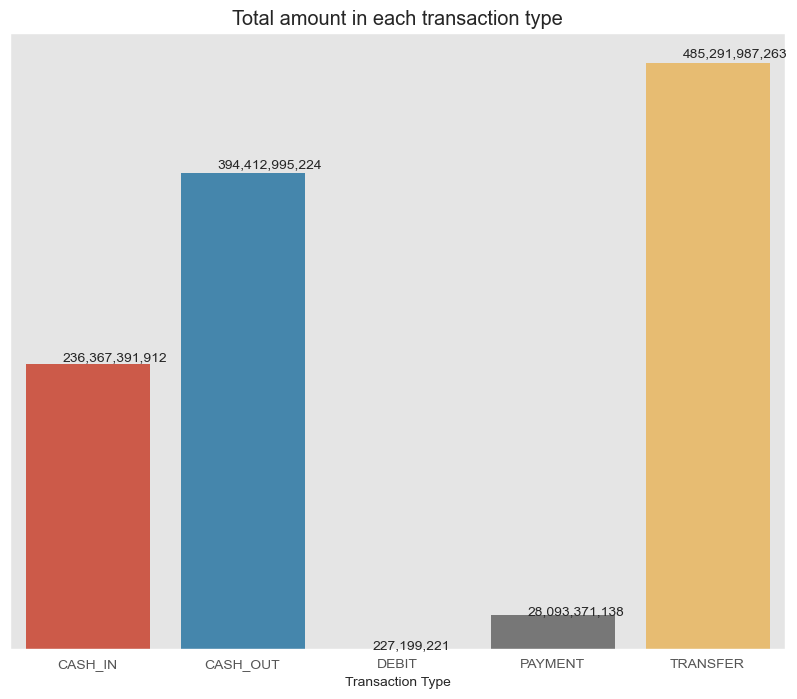

In [64]:
d = df.groupby('type')['amount'].sum()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.title("Total amount in each transaction type")
plt.yticks([])
plt.xlabel("Transaction Type")
plt.show()

From the above visuals, we observe that the distribution of payment types does not coincide with the amount flowing through each transaction. As an example, we see that whilst the "payment" transaction type makes up over 30% of all transaction types, the total amount that flows through this payment type constitutes less than 5% of total transaction values.

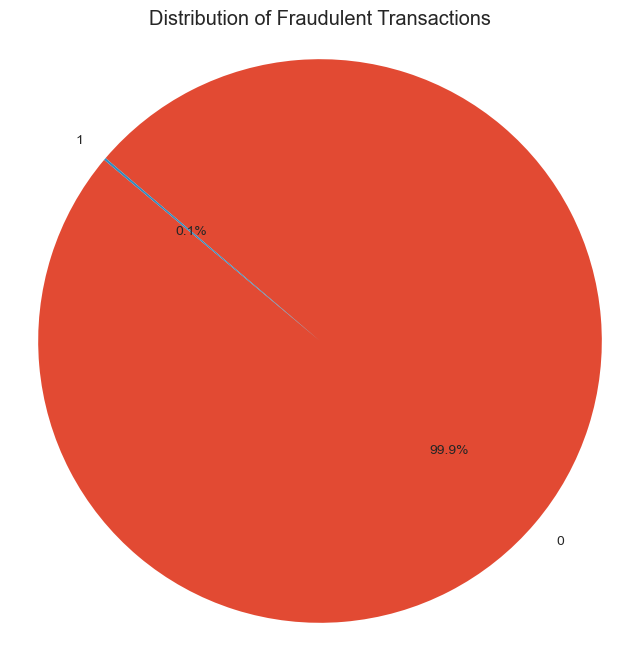

In [65]:
# Count the frequency of each unique value in the 'isFraud' column
fraud_counts = df['isFraud'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraudulent Transactions')
plt.axis('equal')  
plt.show()

We see that about 99.9% of captured transactions are non-fraudulent and the remainder 0.1% captured as fraudulent transactions.

<Axes: title={'center': 'Distribution of Transaction Amount'}, xlabel='type', ylabel='amount'>

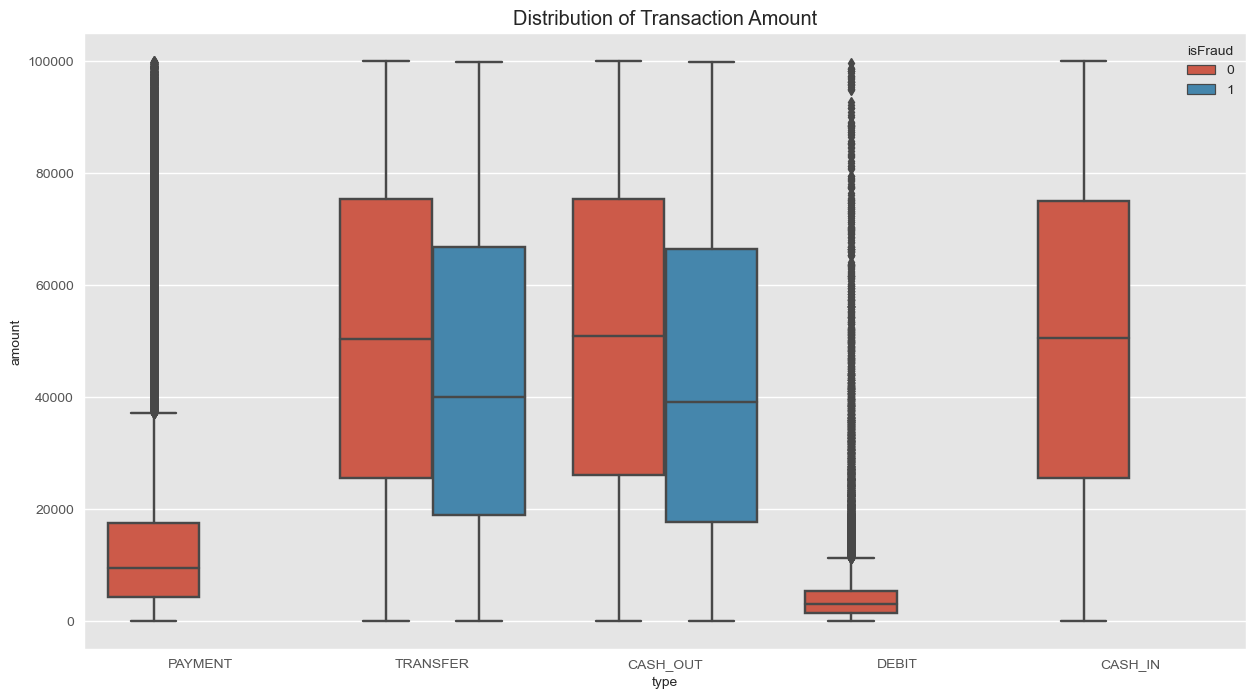

In [66]:
plt.figure(figsize=(15,8))
plt.title("Distribution of Transaction Amount")
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df[df.amount < 1e5])

The above diagram illustrates a boxplot showing the distribution of transaction amounts across different transaction types, with each box colored based on whether the transaction is fraudulent or not. From the above we note that fraudulent transactions are more prevelant amongst "transfer" and "Cash out" means of transaction.

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


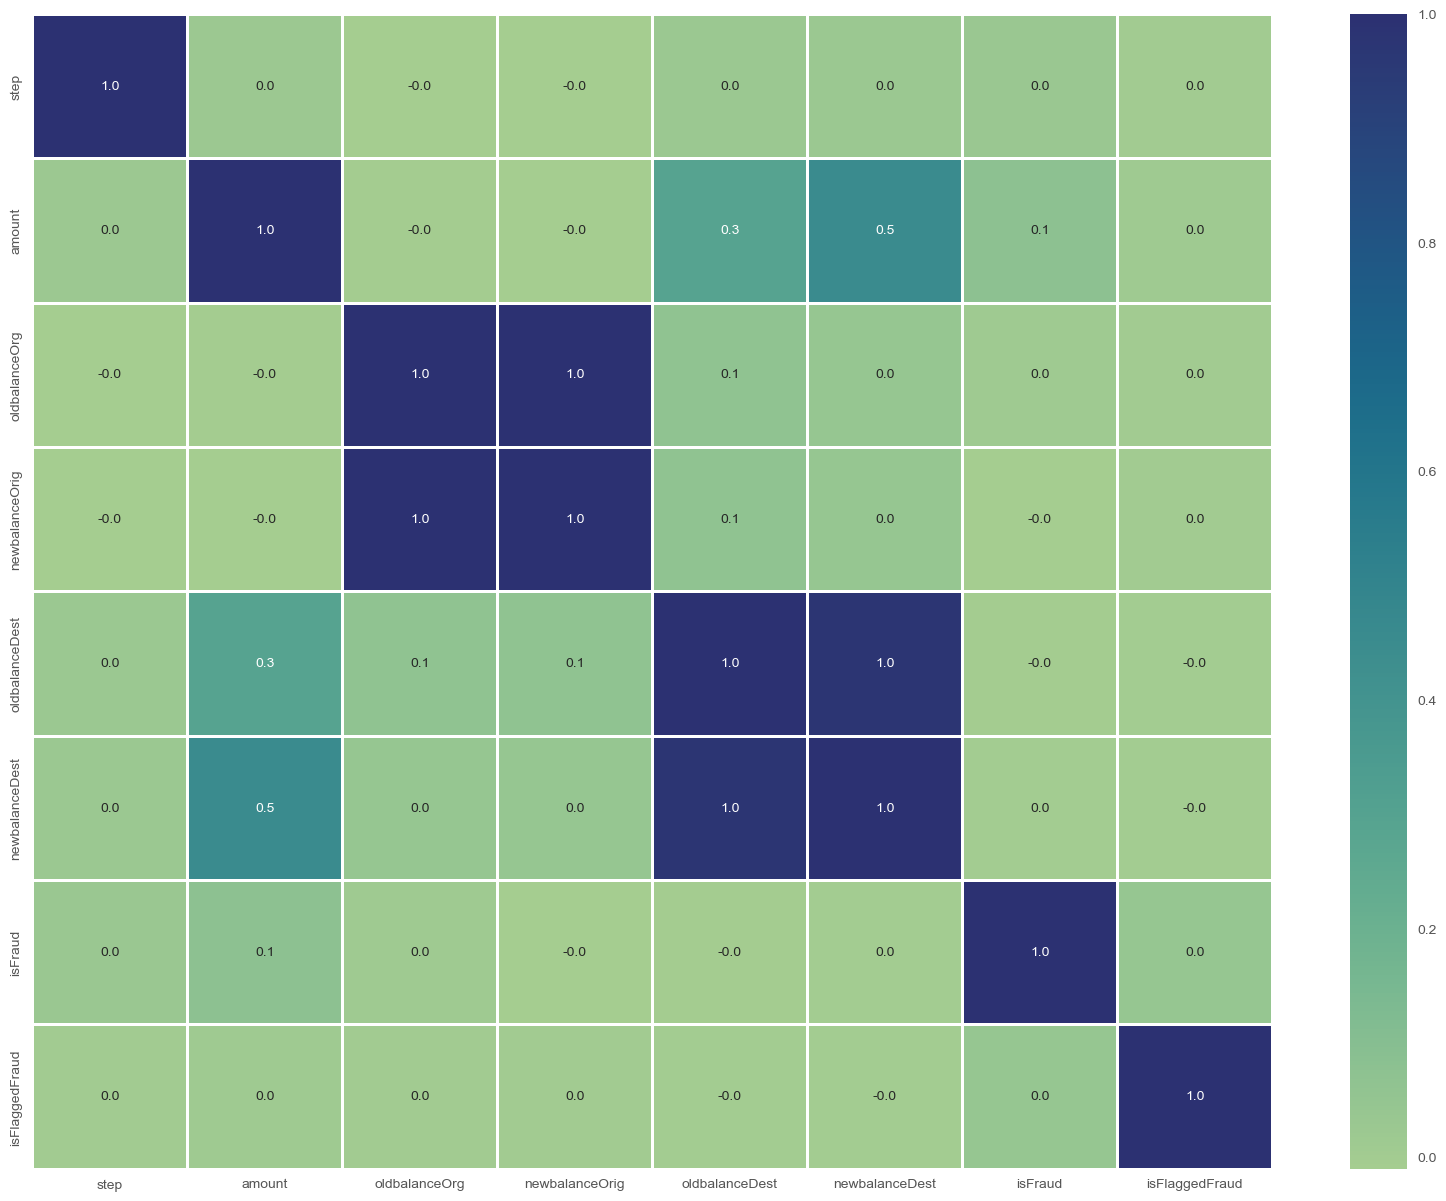

In [67]:
# How are the variables correlated ?

correlation = df.corr()
print (correlation["isFraud"].sort_values(ascending = False))

fig = plt.figure(figsize= (20,15))
sns.heatmap(
            data = df.corr(), annot = True, fmt ='0.1f', linewidths=1,cmap='crest'
)

plt.show()

*Given that the task is to develop a model that predicts whether or not a payment is fraudulent, it may be advisable to drop the columns "oldbalanceDest" as well as "newbalanceOrig " given their negative correlation to the target variable 'isFraud'

4.DATA PREPROCESSING

After cleaning our data, understanding it and addressing any issues surrounding null values, we now turn our attention to ensuring that our data set is ready to be passed into our ML model. This may require encoding ceratin column (making them readable by the model), dropping some columns to reduce complexity and scaling to ensure that every entry is equally weighted by our model. 

4.1. Hot Encoding

The column "type" is a categorical column, therefore we need to encode in such a manner that makes it easy for our model to interpret it in determining whether or not a payment is fraudulent.

Moreover, we also make it clear what the code '0' & '1' under the "isFraud" column, making it easier to read the ouput from our model.

In [68]:
df["type"] = df["type"].map({"CASH_OUT":1, "PAYMENT":2,
                               "CASH_IN":3, "TRANSFER":4,
                               "DEBIT":5})

df["isFraud"] = df["isFraud"].map({0:"No Fraud", 1:"Fraud"})

In [69]:
## Let us now drop unrequired columns

df.drop(['step','nameOrig','nameDest','isFlaggedFraud','oldbalanceDest','newbalanceOrig'],axis=1,inplace=True)
df['type'] = pd.factorize(df['type'], sort=True)[0]
df.head()

,type,amount,oldbalanceOrg,newbalanceDest,isFraud
0,1,9839.64,170136.0,0.0,No Fraud
1,1,1864.28,21249.0,0.0,No Fraud
2,3,181.00,181.0,0.0,Fraud
3,0,181.00,181.0,0.0,Fraud
4,1,11668.14,41554.0,0.0,No Fraud


In [70]:
plt.figure(figsize=(12,8))
sns.pairplot(df[['amount', 'oldbalanceOrg', 'type', 'isFraud']], hue='isFraud')

Once again, from the above pairplots, we observe that it is only the "Transfer" and "Cash_out" transaction types that contain fraudulent transactions, indicating that we may drop the other two types of transactions in our supervised model.

 SCALING CONTINUOUS VALUES

While we have observed that we do not have any missing values and thus no need for imputers, it may be wiser to scale the continuous values to ensure to avoid any biases and ensure that all entries contribute equally to the result. In this particular project, we use the STANDARD SCALER methodology.

In [71]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes('object').columns.tolist()

In [72]:
numeric_columns

['type', 'amount', 'oldbalanceOrg', 'newbalanceDest']

In [73]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df[numeric_columns])
df[numeric_columns] = scaler.transform(df[numeric_columns])

In [74]:
df.head(10)

,type,amount,oldbalanceOrg,newbalanceDest,isFraud
0,-0.056384,-0.281560,-0.229810,-0.333411,No Fraud
1,-0.056384,-0.294767,-0.281359,-0.333411,No Fraud
2,1.982567,-0.297555,-0.288654,-0.333411,Fraud
3,-1.075860,-0.297555,-0.288654,-0.333411,Fraud
4,-0.056384,-0.278532,-0.274329,-0.333411,No Fraud
5,-0.056384,-0.284908,-0.270068,-0.333411,No Fraud
6,-0.056384,-0.286084,-0.225289,-0.333411,No Fraud
7,-0.056384,-0.284836,-0.227750,-0.333411,No Fraud
8,-0.056384,-0.291190,-0.287792,-0.333411,No Fraud
9,3.002042,-0.289015,-0.274272,-0.322430,No Fraud


Now our data has been scaled across all columns.

5. Model Building and Validation

Having cleaned and preprocessed our dataset, we now run a number of supervised machine learning algorithms as we try to determine the most appropriate for our objective and dataset

In [83]:
from sklearn.model_selection import train_test_split

x = np.array(df[["type", "amount", "oldbalanceOrg","newbalanceDest"]])
y = np.array(df[["isFraud"]])

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, random_state=42)

models = []
results = []
names = []

models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Dummy', DummyClassifier(strategy="uniform")))

for name, model in models:
    model.fit(xtrain, ytrain)
    accuracy = model.score(xtest, ytest)
    results.append(accuracy)
    names.append(name)

    print(f"{name} Accuracy = {accuracy}")


Decision Tree Accuracy = 0.9994860607737064
NB Accuracy = 0.9867059481785805
Logistic Regression Accuracy = 0.9987308687301772
KNN Accuracy = 0.9995897916267198
Dummy Accuracy = 0.5002695430498757


In [84]:
df["isFraud"] = df["isFraud"].map({"No Fraud":0, "Fraud":1})

In [85]:
from sklearn.model_selection import train_test_split

x = np.array(df[["type", "amount", "oldbalanceOrg","newbalanceDest"]])
y_1 = np.array(df["isFraud"])

xtrain, xtest, y_train, y_test = train_test_split(x, y_1, test_size=0.20, random_state=42)

models_c = []
results_c = []
names_c = []

models_c.append(('ADA', AdaBoostClassifier()))
models_c.append(('XGB', XGBClassifier()))


for name, model in models_c:
    model.fit(xtrain, y_train)
    accuracy = model.score(xtest, y_test)
    results_c.append(accuracy)
    names_c.append(name)

    print(f"{name} Accuracy = {accuracy}") 

ADA Accuracy = 0.9989642631494573
XGB Accuracy = 0.9996275119369065


Having ran the above 6 models, we observe that the XGBoost has the highest accuracy and as such, we will be using this model for our projeect.

In [87]:
xgb = XGBClassifier()
xgb.fit(xtrain, y_train)
y_prediction = xgb.predict(xtest)
accuracy = accuracy_score(y_test, y_prediction)

print('Final accuracy of the model is {}%'.format(accuracy * 100))


Final accuracy of the model is 99.96275119369065%
Classification Report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.73      0.83      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix 
[[1270866      38]
 [    436    1184]]


In [88]:
print('Classification Report \n{}'.format(classification_report(y_test, y_prediction)))

Classification Report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.73      0.83      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



In [89]:
print('Confusion Matrix \n{}'.format(confusion_matrix(y_test, y_prediction)))

Confusion Matrix 
[[1270866      38]
 [    436    1184]]


We see from both the confusion matrix and the classification report that the XGBoost model does a good job at classiying and identifying defaulters and non-defaulters.

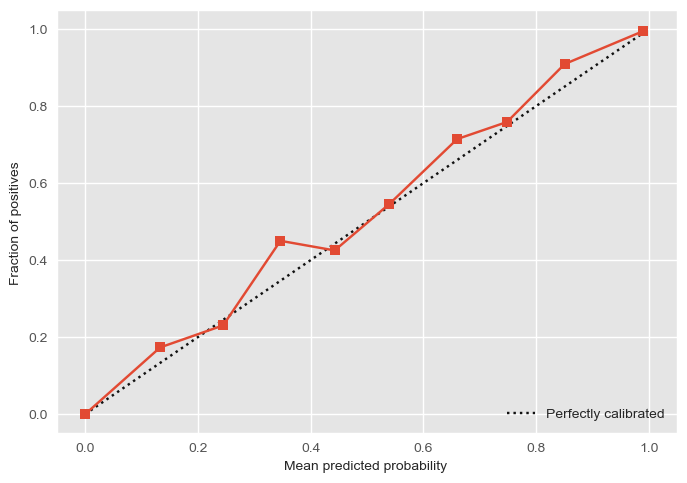

In [90]:
y_prob = xgb.predict_proba(xtest)[:,1]
prob_true , prob_pred = calibration_curve(y_test,y_prob,n_bins=10)
display = CalibrationDisplay(prob_true,prob_pred,y_prob)
display.plot()

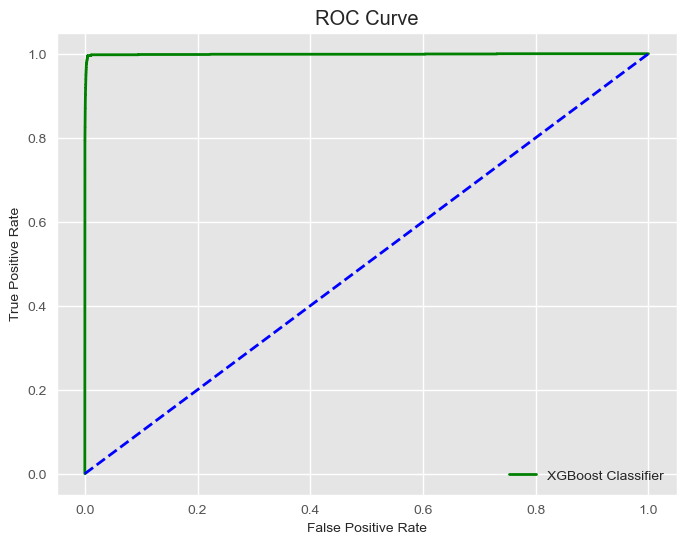

In [91]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='XGBoost Classifier')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

Finally, from the above ROC curve, we observe that the curve line is above the tpr = fpr line and thus we can conclude that
XGBoost classifier line curve proves that model did good job in correctly identifying the defaulters.